In [1]:
import yaml
import argparse
import itertools
from collections import defaultdict
from pathlib import Path
import multiprocessing
from multiprocessing import Pool, cpu_count
import concurrent.futures
from typing import Dict, List
from src.runner import Runner
import os
from src.plotPR import PRCurves

class InputSettings(object):
    def __init__(self,
            datadir, datasets, algorithms) -> None:
        
        self.datadir = datadir
        self.datasets = datasets
        self.algorithms = algorithms

class OutputSettings(object):
    '''
    Structure for storing the names of directories that output should
    be written to
    '''

    def __init__(self, base_dir: Path) -> None:
        self.base_dir = base_dir

        
class Evaluation(object):
    '''
    The Evaluation object is created by parsing a user-provided configuration
    file. Its methods provide for further processing its inputs into
    a series of jobs to be run, as well as running these jobs.
    '''

    def __init__(self,
            input_settings: InputSettings,
            output_settings: OutputSettings) -> None:

        self.input_settings = input_settings
        self.output_settings = output_settings
        self.runners: Dict[int, Runner] = self.__create_runners()


    def __create_runners(self) -> Dict[int, List[Runner]]:
        '''
        Instantiate the set of runners based on parameters provided via the
        configuration file. Each runner is supplied an interactome, collection,
        the set of algorithms to be run, and graphspace credentials, in
        addition to the custom parameters each runner may or may not define.
        '''
        
        runners: Dict[int, Runner] = defaultdict(list)
        order = 0
        for dataset in self.input_settings.datasets:
            for runner in self.input_settings.algorithms:
                data = {}
                data['name'] = runner[0]
                data['params'] = runner[1]
                data['inputDir'] = Path.cwd().joinpath(self.input_settings.datadir.joinpath(dataset['name']))
                print(data['inputDir'])
                runners[order] = Runner(data)
                order += 1            
        return runners


    def execute_runners(self, parallel=False, num_threads=1):
        '''
        Run each of the algorithms
        '''

        base_output_dir = self.output_settings.base_dir

        batches =  self.runners.keys()

        for batch in batches:
            if parallel==True:
                executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
                futures = [executor.submit(runner.run, base_output_dir)
                    for runner in self.runners[batch]]
                
                # https://stackoverflow.com/questions/35711160/detect-failed-tasks-in-concurrent-futures
                # Re-raise exception if produced
                for future in concurrent.futures.as_completed(futures):
                    future.result()
                executor.shutdown(wait=True)
            else:
                for runner in self.runners[batch]:
                    runner.run(output_dir=base_output_dir)
                    
            
    def PR_runners(self):
        '''
        Plot PR curves for each dataset
        for all the algorithms
        '''
        for dataset in self.input_settings.datasets:              
            PRCurves(dataset, self.input_settings)
                
                
class ConfigParser(object):
    '''
    Define static methods for parsing a config file that sets a large number
    of parameters for the pipeline
    '''
    @staticmethod
    def parse(config_file_handle) -> Evaluation:
        config_map = yaml.load(config_file_handle)
        return Evaluation(
            ConfigParser.__parse_input_settings(
                config_map['input_settings']),
            ConfigParser.__parse_output_settings(
                config_map['output_settings']))

    @staticmethod
    def __parse_input_settings(input_settings_map) -> InputSettings:
        input_dir = input_settings_map['input_dir']
        dataset_dir = input_settings_map['dataset_dir']
        datasets = input_settings_map['datasets']

        return InputSettings(
                Path(input_dir, dataset_dir),
                datasets,
                ConfigParser.__parse_algorithms(
                input_settings_map['algorithms']))


    @staticmethod
    def __parse_algorithms(algorithms_list):
        algorithms = []
        for algorithm in algorithms_list:
                combos = [dict(zip(algorithm['params'], val))
                    for val in itertools.product(
                        *(algorithm['params'][param]
                            for param in algorithm['params']))]
                for combo in combos:
                    algorithms.append([algorithm['name'],combo])
            

        return algorithms

    @staticmethod
    def __parse_output_settings(output_settings_map):
        output_dir = Path(output_settings_map['output_dir'])
        return OutputSettings(output_dir)

def get_parser() -> argparse.ArgumentParser:
    '''
    :return: an argparse ArgumentParser object for parsing command
        line parameters
    '''
    parser = argparse.ArgumentParser(
        description='Run pathway reconstruction pipeline.')

    parser.add_argument('--config', default='config.yaml',
        help='Configuration file')

    return parser

def parse_arguments():
    '''
    Initialize a parser and use it to parse the command line arguments
    :return: parsed dictionary of command line arguments
    '''
    parser = get_parser()
    opts = parser.parse_args()

    return opts


In [2]:
with open("config.yaml", 'r') as conf:
    evaluation = ConfigParser.parse(conf)
print(evaluation)
print('Evaluation started')

# Do something

print('Evaluation complete')

/home/adyprat/ModelEval/inputs/simulated/dataset1
/home/adyprat/ModelEval/inputs/simulated/dataset1
Evaluation started
Evaluation complete


In [ ]:
evaluation.input_settings.datasets

In [4]:
for alg in evaluation.input_settings.algorithms:
    print(alg)

['SCODE', {'should_run': True, 'nGenes': 100, 'z': 4, 'nCells': 356, 'iIter': 100, 'nRep': 2}]
['SCNS', {'should_run': False}]


In [5]:
Path.cwd().joinpath(evaluation.input_settings.datadir)

PosixPath('/home/adyprat/ModelEval/inputs/simulated')

In [6]:
evaluation.runners[0].generateInputs()

In [5]:
#os.system("jupyter nbconvert --to script bench.ipynb")

0

In [5]:
evaluation.input_settings.algorithms

[['SCODE',
  {'should_run': True,
   'nGenes': 100,
   'z': 4,
   'nCells': 356,
   'nIter': 100,
   'nRep': 2}],
 ['SCNS', {'should_run': False}]]

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

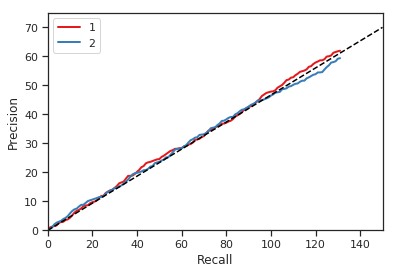

In [10]:
pDict = {}
rDict = {}
#plt.style.use('ggplot')
plt.clf()
sns.set(rc={"lines.linewidth": 2}, palette  = "Set1", style = "ticks")
keys = [1,2]
for key in keys:
    pDict[key] = [0]
    rDict[key] = [0]
    for i in range(0,np.random.randint(100,150)):
        pDict[key].append(pDict[key][-1]+np.random.random())
        rDict[key].append(i)
    
for key in pDict.keys():
    sns.lineplot(rDict[key],pDict[key])

plt.plot([0, 150], [0,70], linewidth = 1.5, color = 'k', linestyle = '--')

plt.xlim(0,150)    
plt.ylim(0,75)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(['1','2']) 
        
